In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('paper')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
from statsmodels.tools.eval_measures import rmse

In [4]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [5]:
sns.set_context('talk')
sns.set_style('white')

In [6]:
plt.rcParams["figure.dpi"] = 600

In [7]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
psizes = [150,120,200,120,350]
pmarkers = ['o', 's', '^', 'D', '*']

# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [8]:
PRO_COLOR = 'MediumSeaGreen'
ALT_COLOR = 'Gold'

In [9]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [10]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [11]:
os.listdir('fcmfiles')

['FCM_exp1_100Days.csv',
 'FCM_exp1_140Days.csv',
 'FCM_exp1_60Days.csv',
 'FCM_exp3_140Days.csv',
 'FCM_exp4_140Days.csv']

In [12]:
dflist=list()
for i in os.listdir('fcmfiles'):
    if i.endswith('.csv'):
        d = pd.read_csv(os.path.join('fcmfiles', i))
        n = os.path.splitext(i)[0]
        _, experiment, day = n.split('_')
        d['experiment'] = experiment
        d['day'] = day.replace('Days','')
        dflist.append(d)
df = pd.concat(dflist)
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [13]:
df.head()

PRO  ALT sample         PRO.1         ALT.1 experiment  day
0     MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100
1     MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100
2     MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100
3  MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100
4  MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100

In [14]:
df.isna().sum()

PRO           45
ALT           45
sample         0
PRO.1         36
ALT.1         73
experiment     0
day            0
dtype: int64

In [15]:
df['day'] = pd.to_numeric(df['day'])

In [16]:
for c in df.columns:
    if c in ['PRO.1', 'ALT.1']:
        continue
    print(c, df[c].unique())

PRO ['MED4' 'MIT9313' 'MIT9312' 'Natl2A' 'MIT0604' nan]
ALT ['1A3' 'DE' 'DE1' 'BS11' 'ATCC' nan]
sample ['1A' '1B' '1C' '2A' '2B' '2C' '3A' '3B' '3C' '4A' '4B' '4C' '5A' '5B'
 '5C' '6A' '6B' '6C' '7A' '7B' '7C' '8A' '8B' '8C' '9A' '9B' '9C' '10A'
 '10B' '10C' '11A' '11B' '11C' '12A' '12B' '12C' '13A' '13B' '13C' '14A'
 '14B' '14C' '15A' '15B' '15C' '16A' '16B' '16C' '17A' '17B' '17C' '18A'
 '18B' '18C' '19A' '19B' '19C' '20A' '20B' '20C' '21A' '21B' '21C' '22A'
 '22B' '22C' '23A' '23B' '23C' '24A' '24B' '24C' '25A' '25B' '25C' '26A'
 '26B' '26C' '27A' '27B' '27C' '28A' '28B' '28C' '29A' '29B' '29C' '30A'
 '30B' '30C' '31A' '31B' '31C' '32A' '32B' '32C' '33A' '33B' '33C' '34A'
 '34B' '34C' '35A' '35B' '35C']
experiment ['exp1' 'exp3' 'exp4']
day [100 140  60]


In [17]:
df.dtypes

PRO            object
ALT            object
sample         object
PRO.1         float64
ALT.1         float64
experiment     object
day             int64
dtype: object

In [18]:
_df = pd.read_pickle('CCPA.pkl.gz')
_df.loc[_df.PRO == 'C9B', 'PRO'] = 'MIT0604'
df1 = _df.loc[(_df.experiment.isin(['e1']))]

In [19]:
day60 = df1.loc[(df1.day >59) & (df1.day < 61), 'day' ].unique()[0]
day100 = df1.loc[(df1.day >100) & (df1.day < 101), 'day' ].unique()[0]
day140 = df1.loc[(df1.day >139) & (df1.day < 141), 'day' ].unique()[0]
df1 = df1.loc[df1.day.isin([day60, day100,day140])]
df1['day'] = df1['day'].map({day60:60, day100:100, day140:140})
df1.experiment = 'exp1'
df1.head()


day experiment sample     FL   PRO  ALT     culture  FL_orig     logFL  \
39    60       exp1     1A  0.558  MED4  1A3  Co_Culture    0.558 -0.583396   
68   100       exp1     1A  0.356  MED4  1A3  Co_Culture    0.356 -1.032825   
87   140       exp1     1A  0.079  MED4  1A3  Co_Culture    0.079 -2.538307   
127   60       exp1     1B  0.680  MED4  1A3  Co_Culture    0.680 -0.385662   
156  100       exp1     1B  0.403  MED4  1A3  Co_Culture    0.403 -0.908819   

     cumsumFL  cumsumlogFL  zscoreFL  diffFL  difflogFL   diffday    rateFL  \
39     95.598    11.366955 -0.376854  -0.029  -0.050666  0.631944 -0.045890   
68    112.389    -4.998736 -0.477633  -0.047  -0.124006  1.059722 -0.044351   
87    115.576   -42.125818 -0.615830  -0.009  -0.107889  1.900000 -0.004737   
127   101.031    15.665516 -0.372846   0.121   0.195943  0.631944  0.191473   
156   120.126     3.203152 -0.513839  -0.045  -0.105857  1.059722 -0.042464   

     ratelogFL experiment_sample  
39   -0.080175            e1, 1A  
68   -0.117017            e1, 1A  
87   -0.056784            e1, 1A  
127   0.310064            e1, 1B  
156  -0.099891            e1, 1B

In [20]:
# add the FL numbers from experiment1 to the table
df = df.merge(df1.loc[:,['day', 'sample', 'FL', 'experiment']], 
        how='left', on=['experiment','sample', 'day'], validate='one_to_one')

In [21]:
df.head()

PRO  ALT sample         PRO.1         ALT.1 experiment  day     FL
0     MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100  0.356
1     MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100  0.403
2     MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100  0.626
3  MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100  0.101
4  MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100  0.050

In [22]:
df_fl = df.dropna(axis=0, subset=['PRO', 'FL'])

In [23]:
# remove the rows where some data is missing. ;leave rows were no data is found but should not be there (e.g. ALT in axenic pro)
df = df.loc[((~df['PRO.1'].isna() & ~df['PRO'].isna()) |
          (~df['ALT.1'].isna() & ~df['ALT'].isna()) )
         ]

In [24]:
df.isna().sum()

PRO            28
ALT            45
sample          0
PRO.1          28
ALT.1          50
experiment      0
day             0
FL            184
dtype: int64

Text(0.5, 1.1, 'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

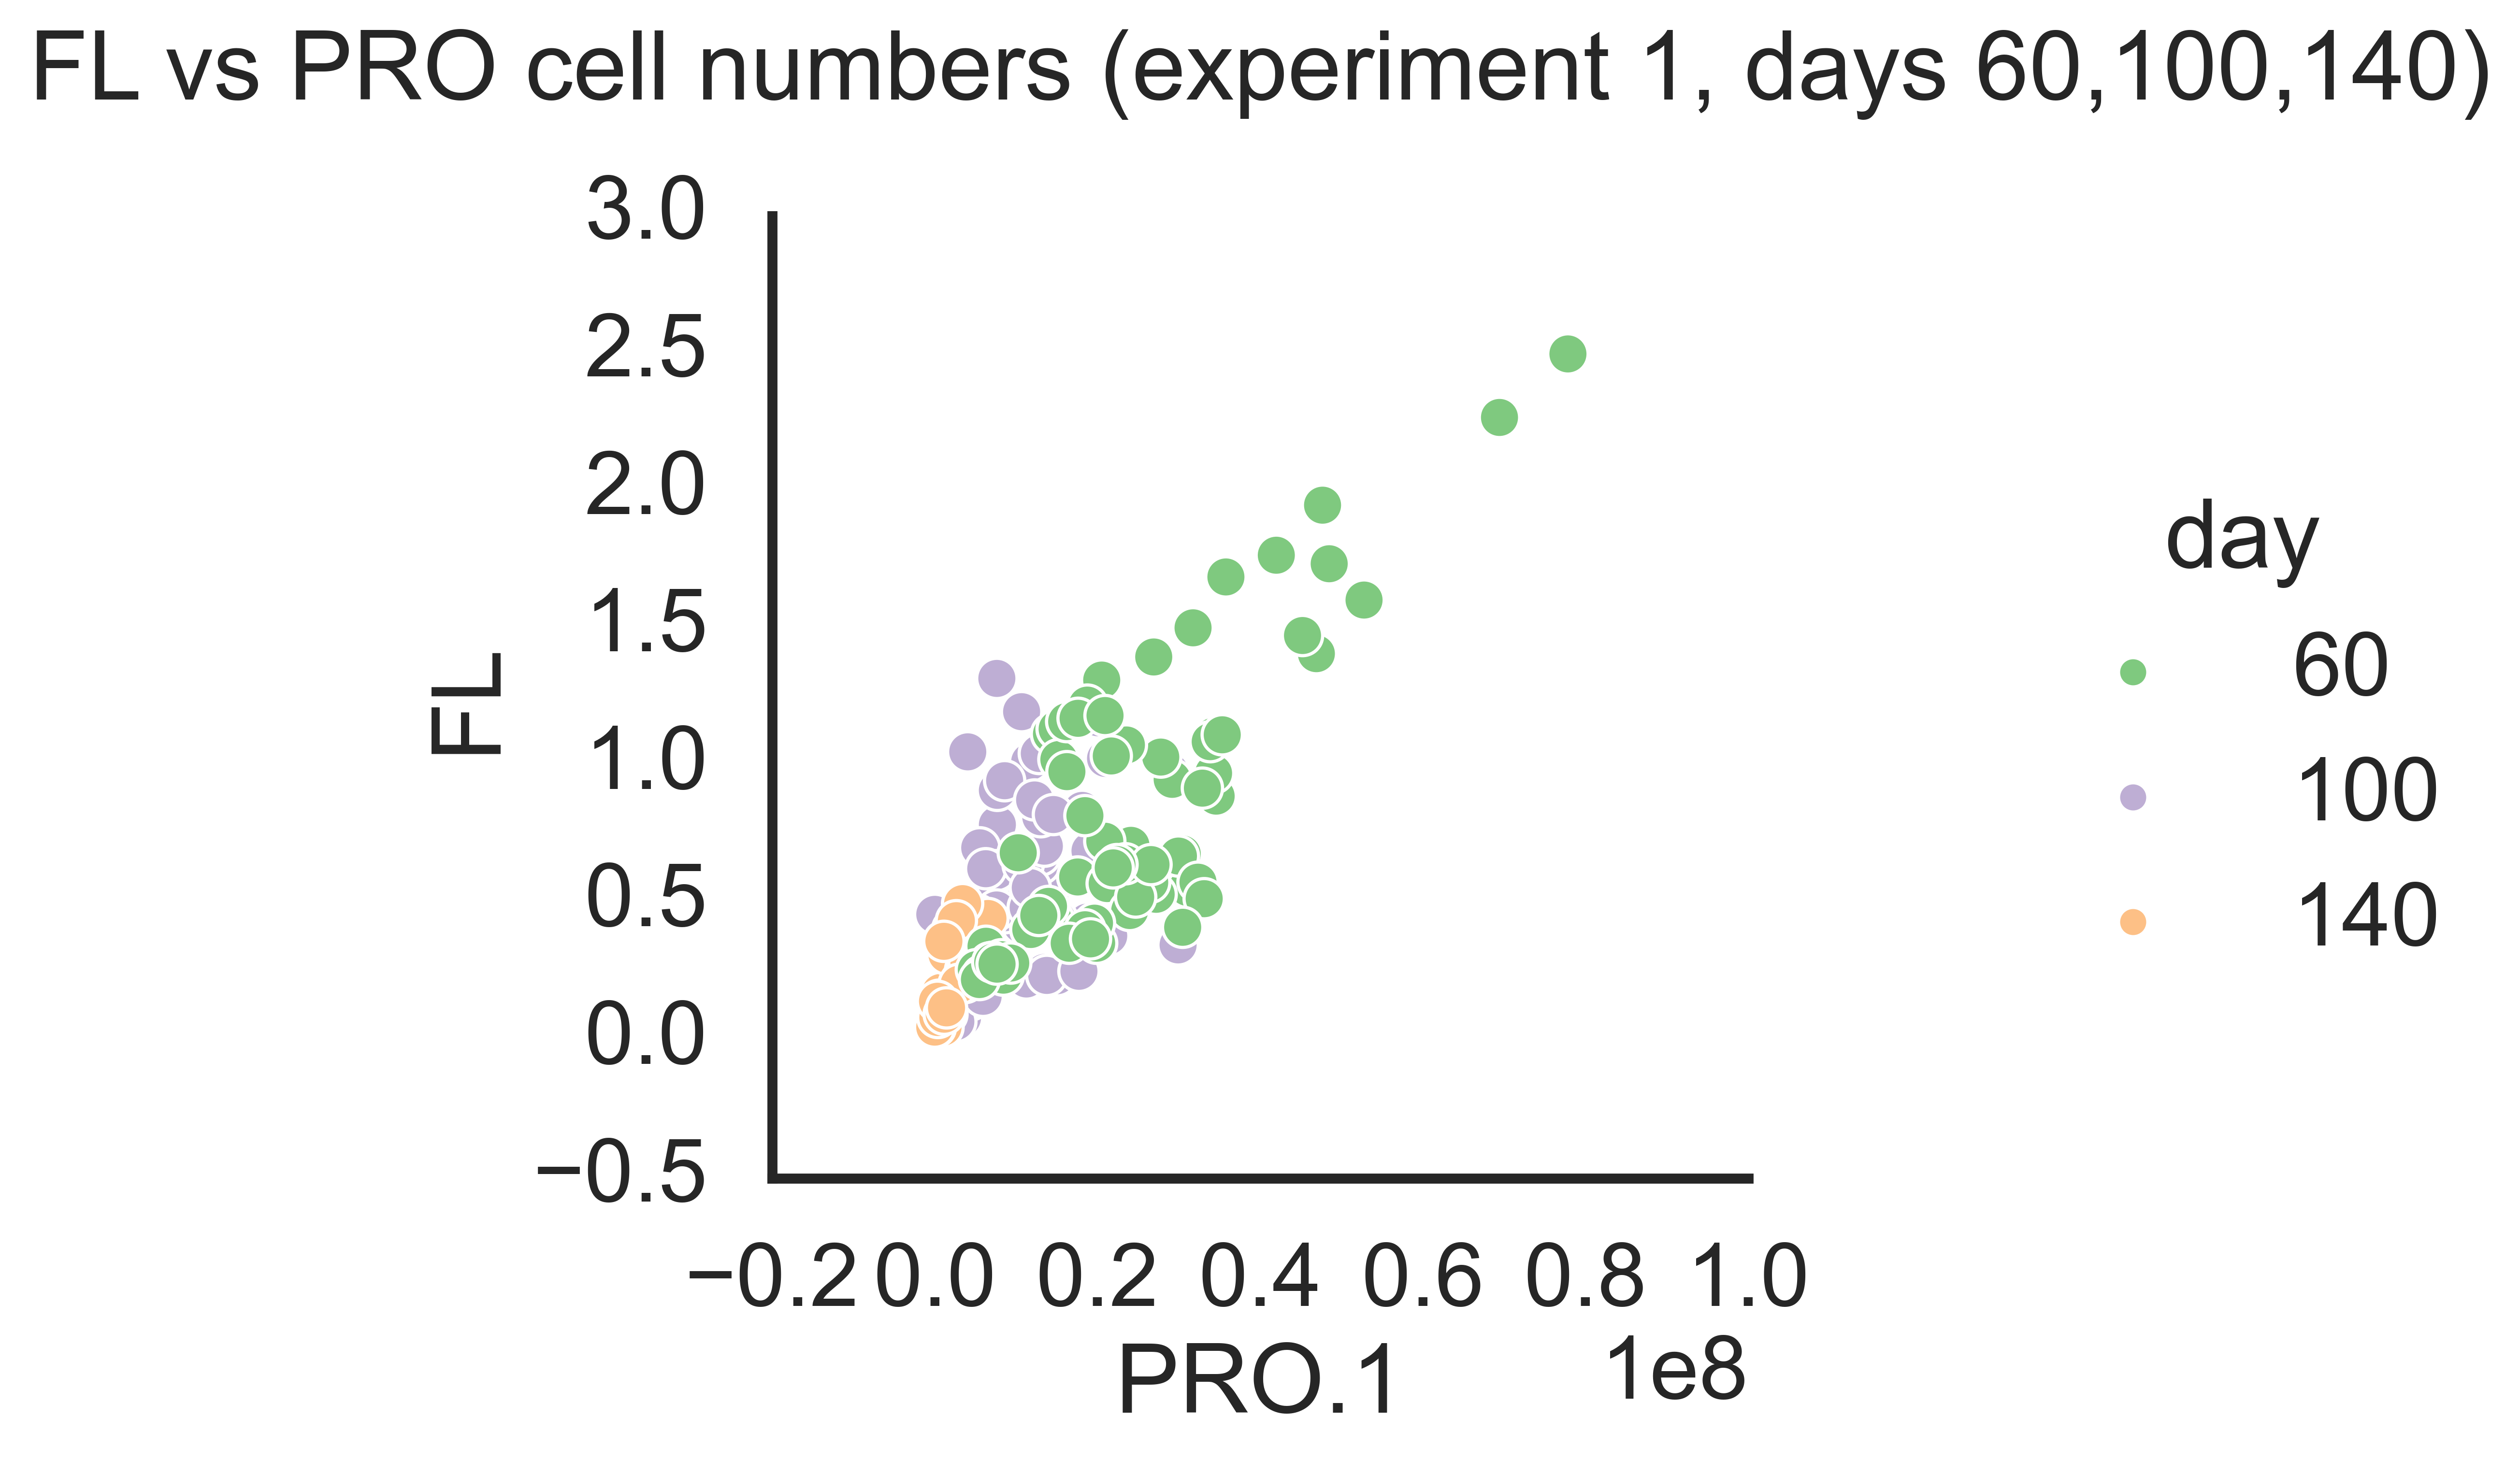

In [85]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', #col='PRO', hue='PRO', 
            legend='full',
           hue='day',
            s=100,
            palette='Accent'
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
          )

plt.title('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

In [90]:
import statsmodels.api as sm

In [26]:
df_fl

PRO  ALT sample         PRO.1         ALT.1 experiment  day     FL
0       MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100  0.356
1       MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100  0.403
2       MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100  0.626
3    MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100  0.101
4    MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100  0.050
..       ...  ...    ...           ...           ...        ...  ...    ...
295  MIT9313  NaN    29B  3.046512e+04           NaN       exp1   60  0.050
296  MIT9313  NaN    29C  3.860465e+04           NaN       exp1   60  0.060
297     MED4  NaN    30A  1.837209e+04           NaN       exp1   60  0.050
298     MED4  NaN    30B  1.348837e+04           NaN       exp1   60  0.050
299     MED4  NaN    30C  1.744186e+04           NaN       exp1   60  0.050

[258 rows x 8 columns]

In [28]:
pdf = cp.get_prev_fcm_df()

In [129]:
    prevfcm_df = cp.get_prev_fcm_df()
    fl_df = prevfcm_df.loc[prevfcm_df.METHOD.isin(['FL']),['EXP','day', 'VALUE']].sort_values(by='day')
    fcm_df = prevfcm_df.loc[prevfcm_df.METHOD.isin(['FCM'])].sort_values(by='day')
    compdf = pd.merge_asof(fcm_df, fl_df, on='day', by='EXP', direction='nearest', suffixes=('','_FL'), tolerance=1 )

    compdf.rename(columns={'VALUE': 'FCM', 'VALUE_FL': 'FL'}, inplace=True)
    compdf.dropna(axis='rows', inplace=True)


In [133]:
compdf.columns, df_fl.columns

(Index(['day', 'FCM', 'EXP', 'METHOD', 'PRO', 'ALT', 'Sample', 'MODE', 'FL'], dtype='object', name=0),
 Index(['PRO', 'ALT', 'sample', 'FCM', 'ALT.1', 'experiment', 'day', 'FL'], dtype='object'))

In [130]:
df_fl.rename(columns = {'PRO.1' : 'FCM'}, inplace=True)

In [141]:
cdf1 = pd.concat([compdf2[['FL', 'FCM', 'PRO', 'day']], df_fl2[['FL', 'FCM', 'PRO', 'day']]])

In [155]:
cdf1.PRO.unique()

array(['MED4', 'MIT9313', 'MIT9312', 'Natl2A', 'MIT0604'], dtype=object)

In [172]:
cdf = cdf1.loc[(cdf1.FL >= 0.2) & (cdf1.FCM >= 1e7) & cdf1.PRO.isin(['MED4'])]

In [170]:
cdf.to_csv('fl_2_fcm_train_MED4.csv.gz')

In [173]:
X = cdf['FL']
y = cdf['FCM']
X.shape, y.shape
res = sm.OLS(y, sm.add_constant(X)).fit()
print(res.summary())
    #return res, compdf

                            OLS Regression Results                            
Dep. Variable:                    FCM   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     318.6
Date:                Fri, 31 Dec 2021   Prob (F-statistic):           3.78e-28
Time:                        16:53:36   Log-Likelihood:                -1336.9
No. Observations:                  74   AIC:                             2678.
Df Residuals:                      72   BIC:                             2682.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.227e+07   3.12e+06      3.940      0.0

# model based on FCM data

In [174]:
dt = res.get_prediction(sm.add_constant(cdf['FL'])).summary_frame(alpha = 0.05)
y_pred = dt['mean']
cdf['ypred'] = y_pred

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [175]:
cdf['error'] = np.absolute(cdf['ypred'] - cdf['FCM'])

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [176]:
cdf['relerror'] = cdf['error'] / cdf['FCM']

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [177]:
cdf.nlargest(10, 'relerror')

FL           FCM   PRO        day         ypred         error  \
1    0.403  6.720907e+06  MED4  100.00000  2.298727e+07  1.626637e+07   
238  0.469  7.920000e+06  MED4   24.67000  2.474186e+07  1.682186e+07   
0    0.356  7.485642e+06  MED4  100.00000  2.173780e+07  1.425215e+07   
2    0.626  1.121335e+07  MED4  100.00000  2.891565e+07  1.770230e+07   
241  0.405  1.181014e+07  MED4   60.00000  2.304044e+07  1.123031e+07   
240  0.444  1.262143e+07  MED4   60.00000  2.407725e+07  1.145582e+07   
242  0.456  1.279493e+07  MED4   60.00000  2.439626e+07  1.160133e+07   
54   1.702  3.140000e+07  MED4    8.73000  5.752074e+07  2.612074e+07   
226  0.489  1.398733e+07  MED4   60.00000  2.527355e+07  1.128623e+07   
57   3.319  5.610901e+07  MED4    8.73125  1.005081e+08  4.439911e+07   

     relerror  
1    2.420264  
238  2.123972  
0    1.903932  
2    1.578681  
241  0.950904  
240  0.907648  
242  0.906713  
54   0.831871  
226  0.806889  
57   0.791301

In [178]:
cdf.nsmallest(10, 'FL')

FL           FCM   PRO     day         ypred         error  relerror
237  0.320  1.280000e+07  MED4   24.67  2.078075e+07  7.980748e+06  0.623496
47   0.349  2.992159e+07  MED4  100.00  2.155170e+07  8.369883e+06  0.279727
0    0.356  7.485642e+06  MED4  100.00  2.173780e+07  1.425215e+07  1.903932
46   0.382  2.139051e+07  MED4  100.00  2.242900e+07  1.038489e+06  0.048549
61   0.382  1.738436e+07  MED4  100.00  2.242900e+07  5.044636e+06  0.290182
45   0.385  2.015988e+07  MED4  100.00  2.250875e+07  2.348868e+06  0.116512
1    0.403  6.720907e+06  MED4  100.00  2.298727e+07  1.626637e+07  2.420264
241  0.405  1.181014e+07  MED4   60.00  2.304044e+07  1.123031e+07  0.950904
257  0.428  1.964311e+07  MED4   60.00  2.365189e+07  4.008780e+06  0.204081
60   0.432  1.874763e+07  MED4  100.00  2.375823e+07  5.010599e+06  0.267266

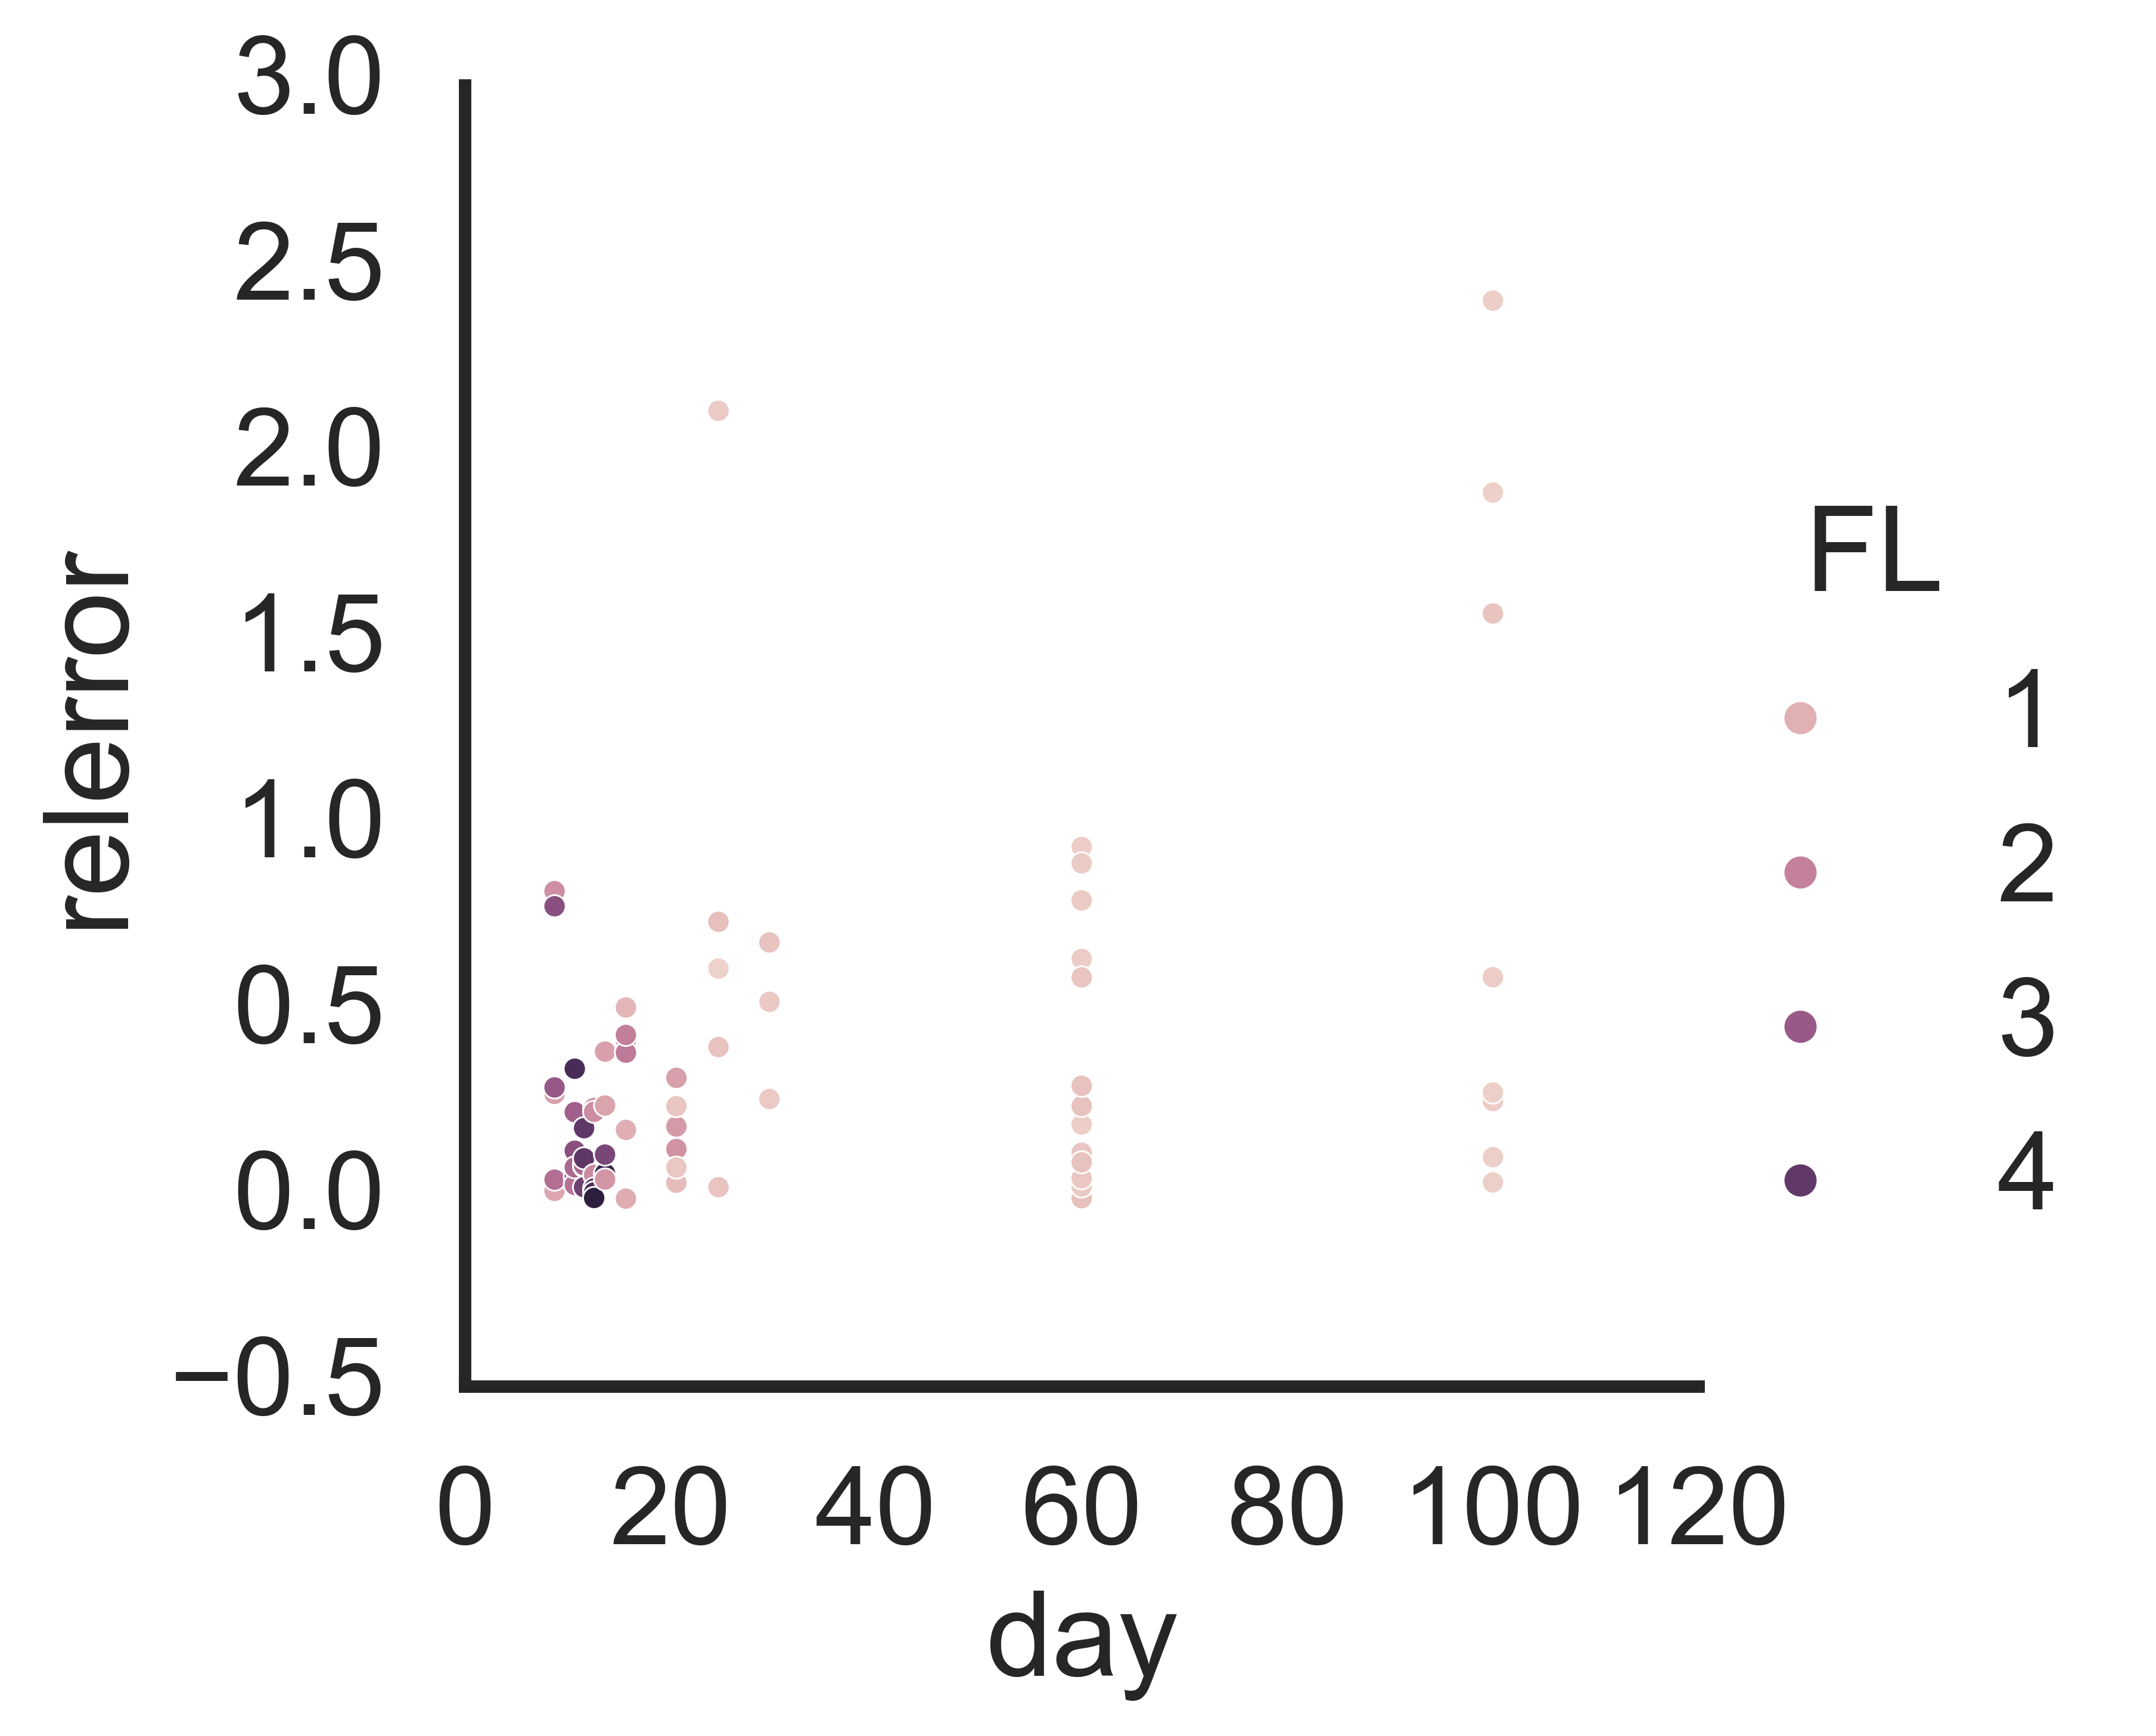

In [179]:
sns.relplot(data=cdf, x=cdf['day'], y=cdf['relerror'], hue='FL')
#plt.yscale('log')


(16982598.884846754, 0.8156601468572491)

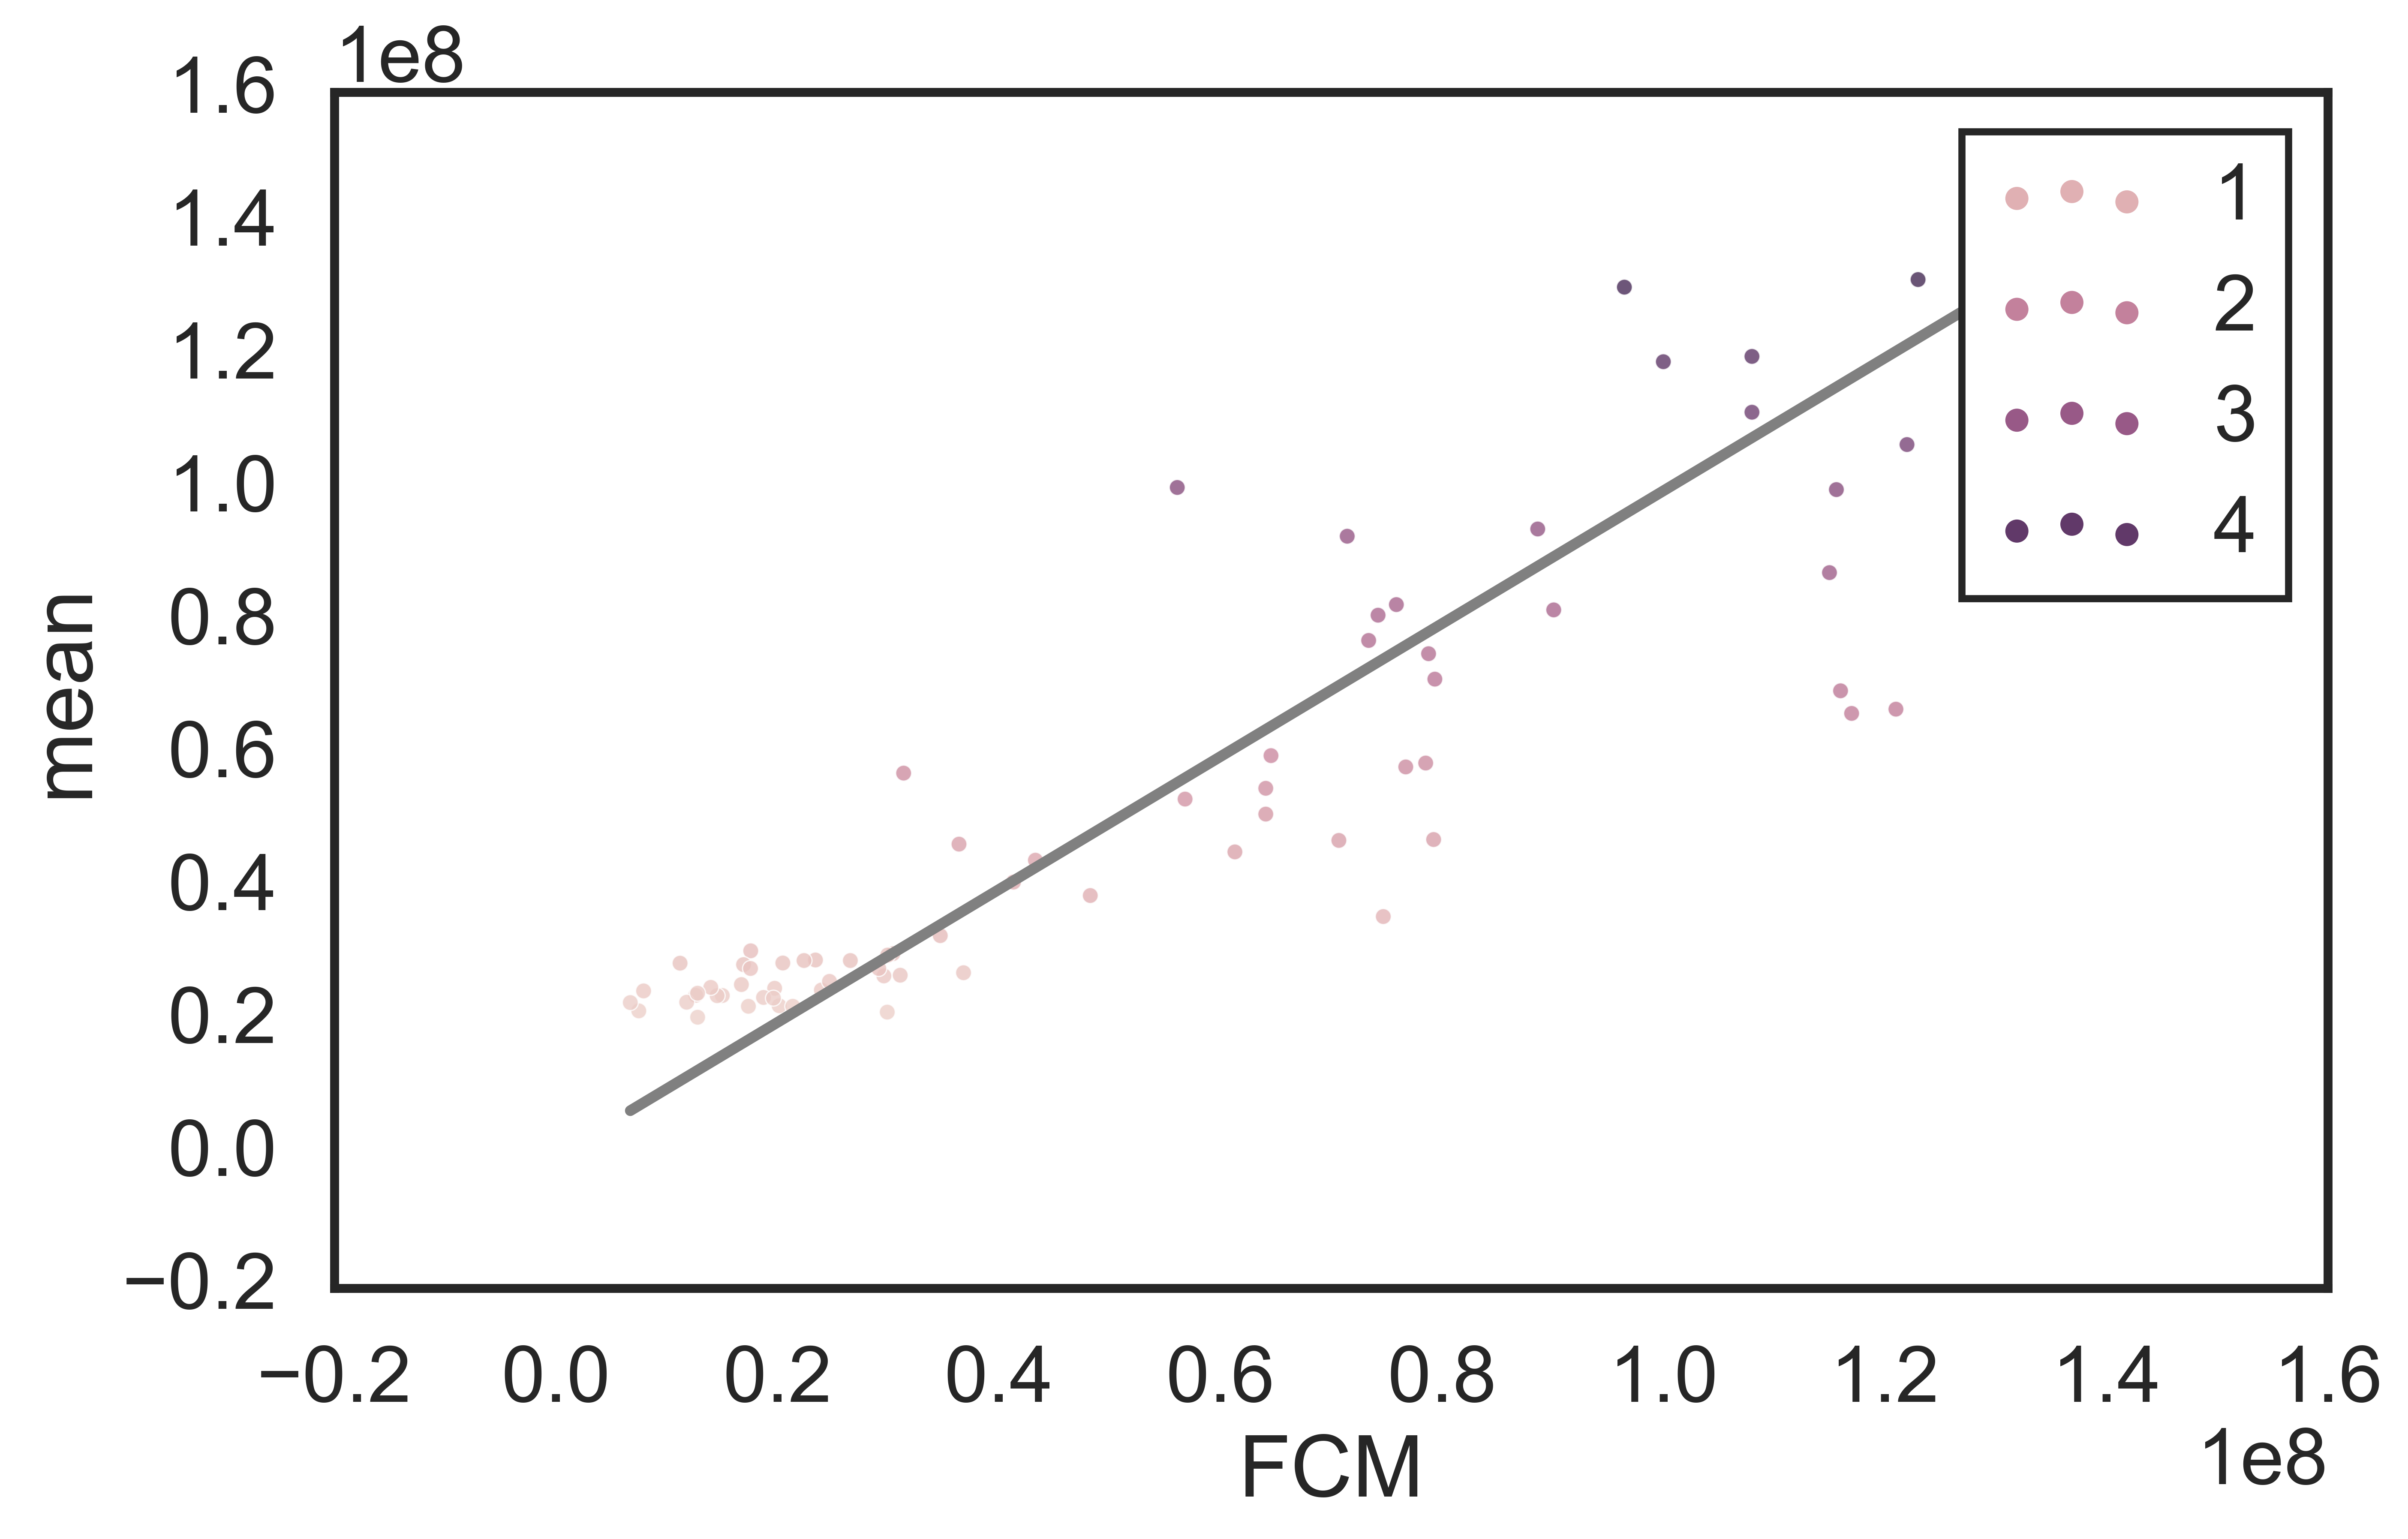

In [180]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style('white')
sns.set_context('poster')
dt = res.get_prediction(sm.add_constant(cdf['FL'])).summary_frame(alpha = 0.05)
y_pred = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

ax=sns.scatterplot(x=cdf.FCM, y=y_pred, 
                   hue=cdf.FL,
                   alpha=0.8
                  )
#sns.lineplot(x=df_fl['FL'], y=y_pred, ax=ax, color='black')
#sns.lineplot(x=df_fl['FL'], y=yprd_ci_lower, color='grey', ax=ax)
#sns.lineplot(x=df_fl['FL'], y=yprd_ci_upper,  color='grey', ax=ax)
sns.lineplot(x=cdf['FCM'], y=cdf['FCM'],  color='grey', ax=ax)


#ax.lines[1].set_linestyle("--")
#ax.lines[2].set_linestyle("--")


#plt.ylabel('cells/ml')
#plt.title('FL vs PRO cell count - experiment 1')
#plt.legend(bbox_to_anchor=(1.5,1))
#plt.legend(markerscale=2.5, bbox_to_anchor=(1.4,1))
#plt.ylim(0,)
#plt.xlim(0,)
#plt.yscale('log')
#plt.xscale('log')
rmse(cdf['FCM'], y_pred), r2_score(cdf['FCM'], y_pred)



In [164]:
(y_pred<0).sum()

0

(38610011.20868079, 0.6410273097269024)

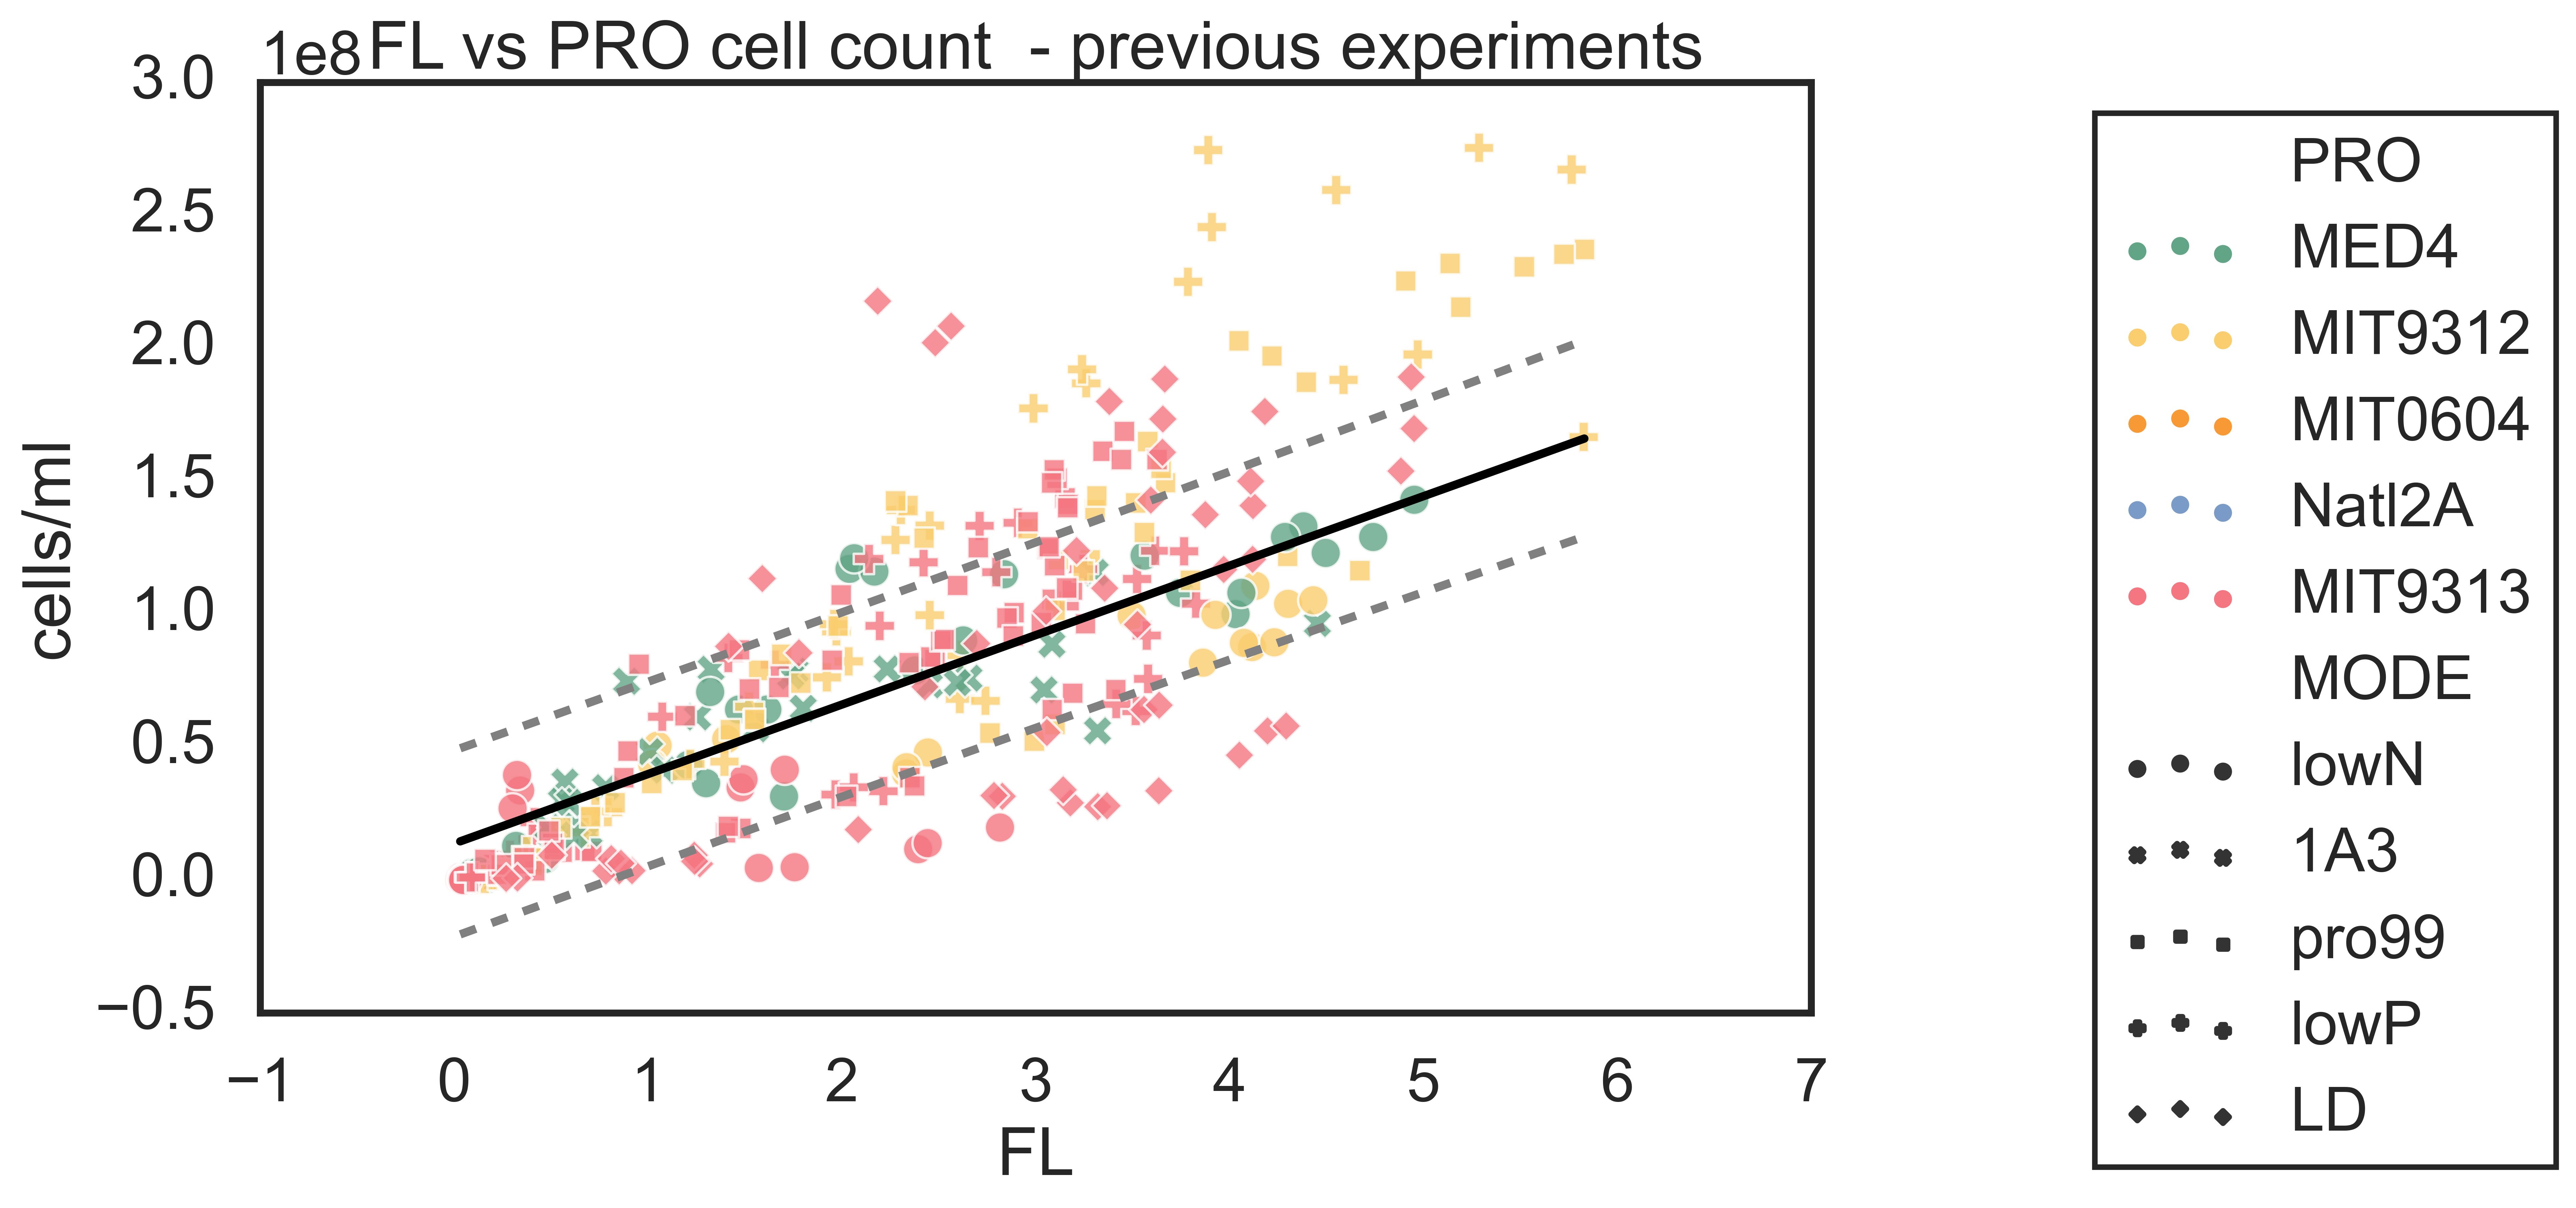

In [168]:
dt = res.get_prediction(sm.add_constant(compdf['FL'])).summary_frame(alpha = 0.05)
y_pred = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

ax = sns.scatterplot(x=compdf.FL, y=compdf.FCM, hue=compdf.PRO, hue_order=porder, palette=ppallete, 
                     style=compdf.MODE, s=120,
                #style='PRO', style_order=porder, markers=pmarkers, size='PRO', size_order=porder, sizes=psizes,
                   alpha=0.8
               )
sns.lineplot(x=compdf['FL'], y=y_pred, color='black', ax=ax)
sns.lineplot(x=compdf['FL'], y=yprd_ci_lower, color='grey', ax=ax)
sns.lineplot(x=compdf['FL'], y=yprd_ci_upper, color='grey', ax=ax)
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
plt.legend(bbox_to_anchor=(1.5,1))

plt.ylabel('cells/ml')
plt.title('FL vs PRO cell count  - previous experiments')


rmse(compdf['FCM'], y_pred), r2_score(compdf['FCM'], y_pred)

(35742173.009640224, 0.6923737015701261)

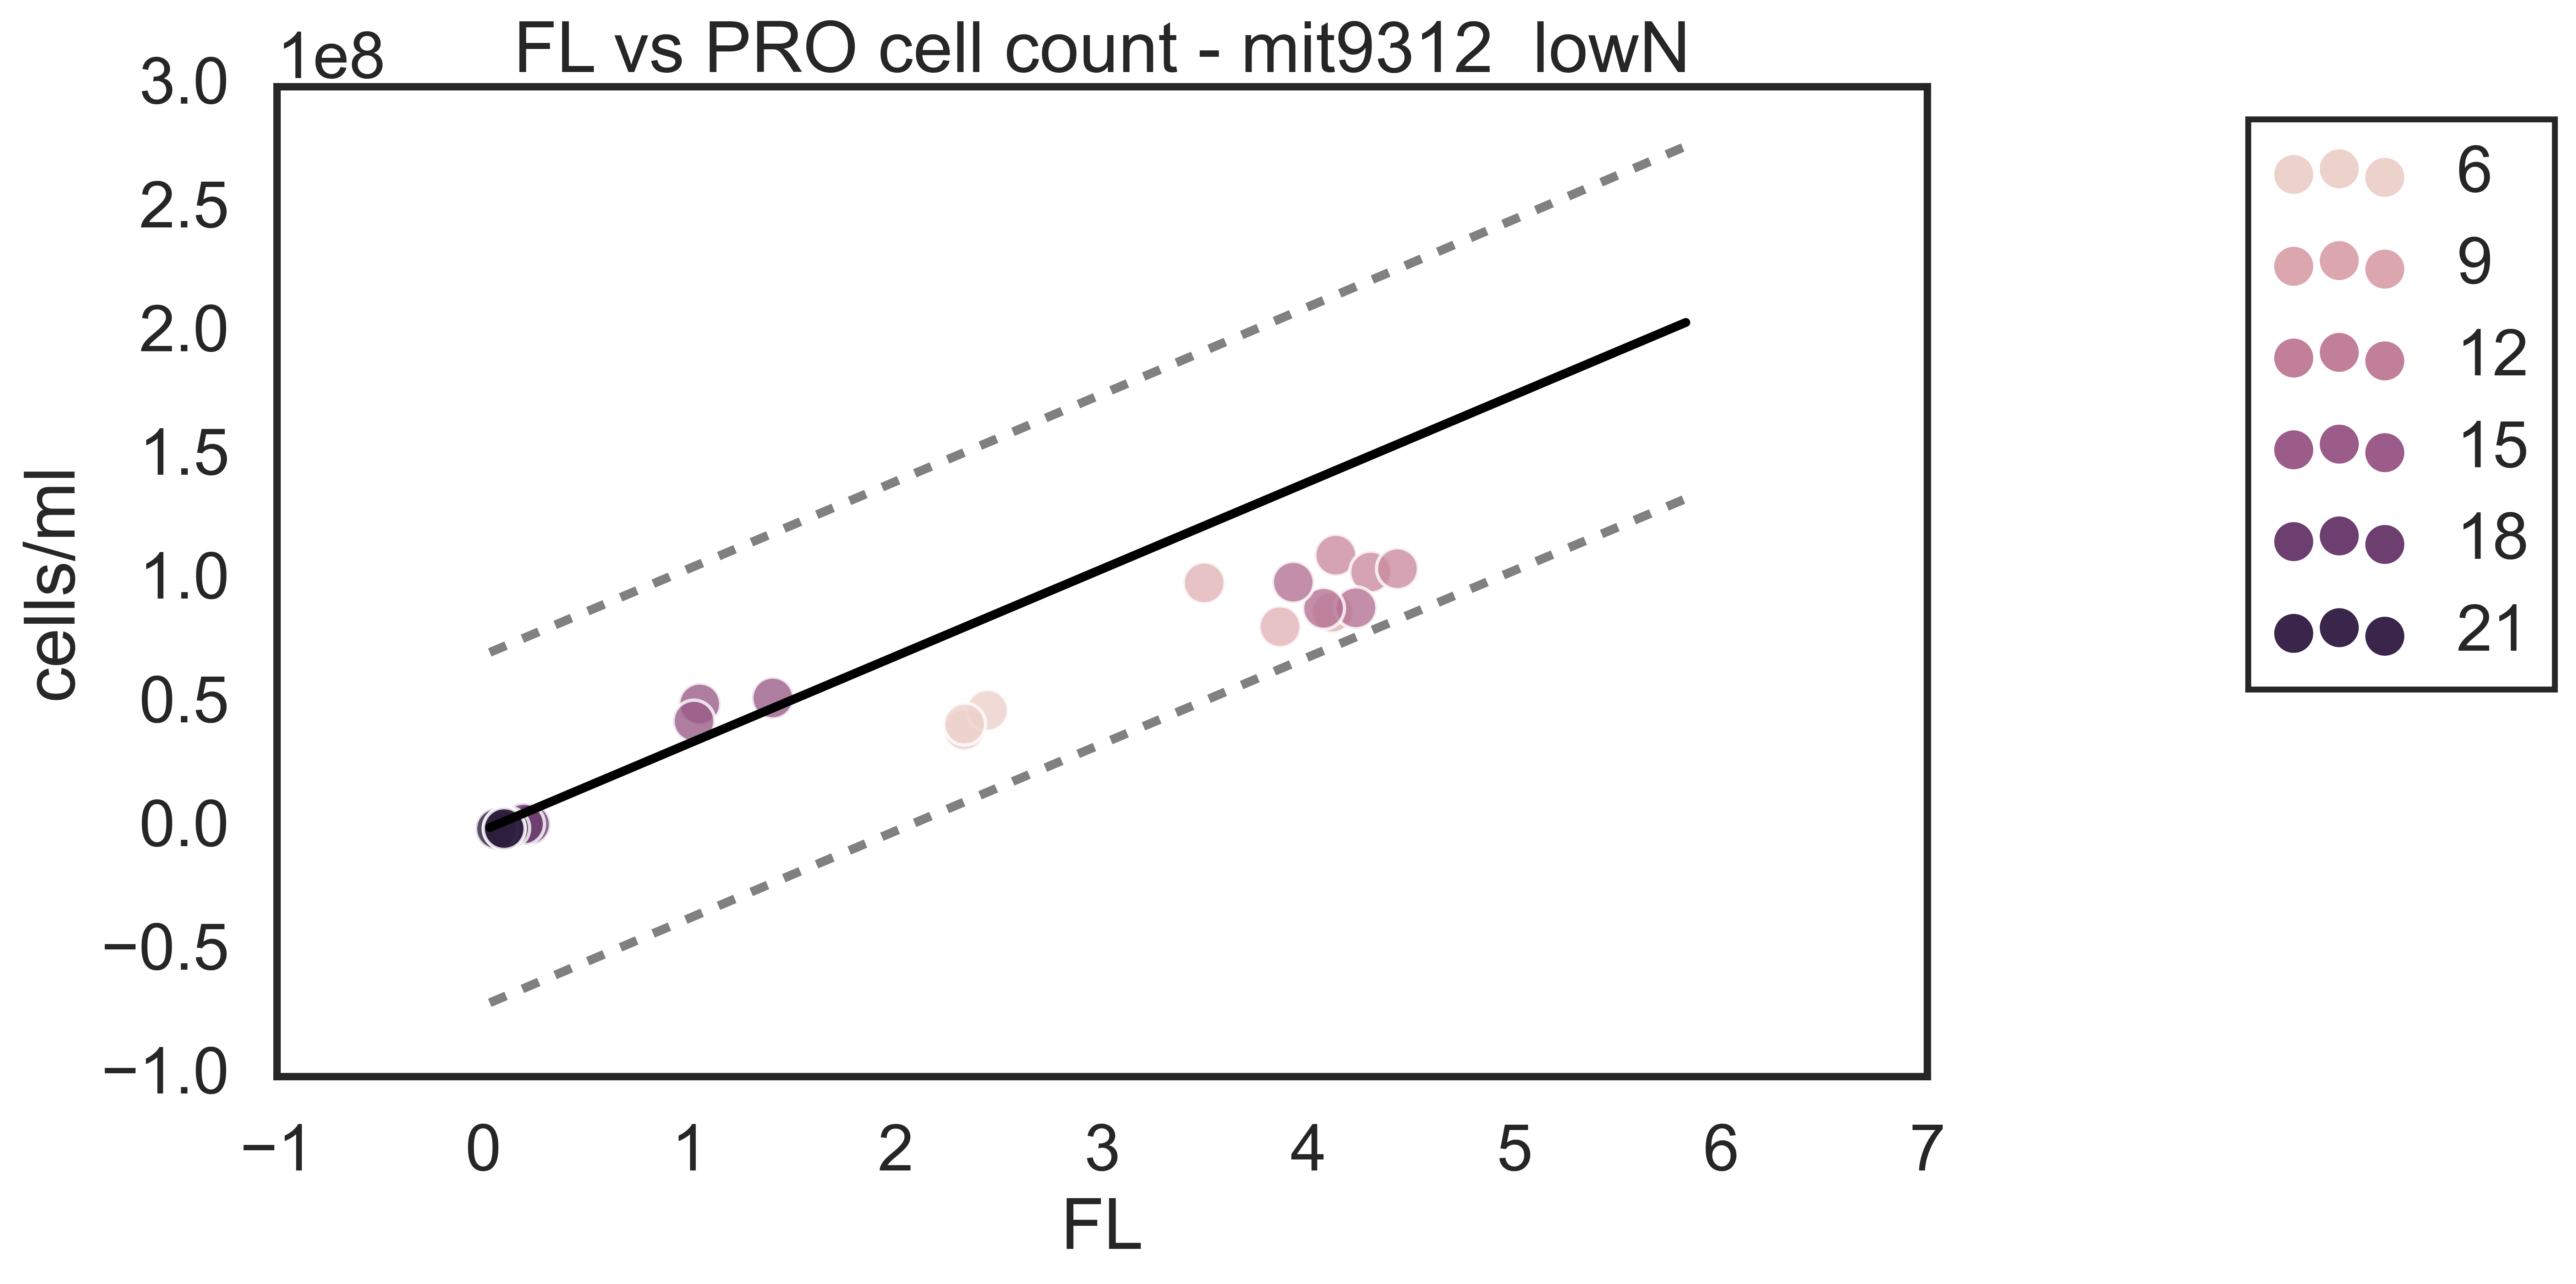

In [115]:
dt = res.get_prediction(sm.add_constant(compdf['FL'])).summary_frame(alpha = 0.05)
y_pred = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
compdf1312N = compdf.loc[compdf.PRO.isin(['MIT9312']) & compdf.MODE.isin(['lowN'])]
ax = sns.scatterplot(x=compdf1312N.FL, y=compdf1312N.FCM, #hue=compdf1.PRO, hue_order=porder, palette=ppallete, 
                     #style=compdf1.MODE, s=120, #size=compdf1.day,
                #style='PRO', style_order=porder, markers=pmarkers, size='PRO', size_order=porder, sizes=psizes,
                   alpha=0.8,
                     hue=compdf1312N.day,
                     s=200
               )
sns.lineplot(x=compdf['FL'], y=y_pred, color='black', ax=ax)
sns.lineplot(x=compdf['FL'], y=yprd_ci_lower, color='grey', ax=ax)
sns.lineplot(x=compdf['FL'], y=yprd_ci_upper, color='grey', ax=ax)
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
plt.legend(bbox_to_anchor=(1.5,1))

plt.ylabel('cells/ml')
plt.title('FL vs PRO cell count - mit9312  lowN')
#for lh in plt.legend.legendHandles: 
#    lh.set_sizes([70])
#handles, labels = ax.get_legend_handles_labels()
#for lh in ax.legend():
#    lh.set_sizes([2000]) 
 
plt.legend(markerscale=2.5, bbox_to_anchor=(1.4,1))
#plt.ylim(0,)
#plt.xlim(0,)
rmse(compdf['FCM'], y_pred), r2_score(compdf['FCM'], y_pred)

In [116]:
prevfcm_df = cp.get_prev_fcm_df()
d = prevfcm_df.loc[prevfcm_df.METHOD == 'FL']
def get_max_day(x):
    maxidx = x['VALUE'].idxmax()
    maxday = x.loc[maxidx]['day']
    return maxday
max_days = d.groupby('EXP').apply(get_max_day)
decline_compdf = compdf.loc[compdf['day'] >= max_days[compdf['EXP']].values]

In [117]:
#decline_compdf1 = decline_compdf.loc[decline_compdf.MODE.isin(['lowN', '1A3'])]
X = decline_compdf['FL']
y = decline_compdf['FCM']
res = sm.OLS(y, sm.add_constant(X)).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    FCM   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     1033.
Date:                Mon, 06 Sep 2021   Prob (F-statistic):           2.89e-85
Time:                        11:53:53   Log-Likelihood:                -4146.9
No. Observations:                 223   AIC:                             8298.
Df Residuals:                     221   BIC:                             8305.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.097e+06   3.08e+06      0.357      0.7

In [118]:
df_fl.head()

PRO  ALT sample         PRO.1         ALT.1 experiment  day     FL
0     MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100  0.356
1     MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100  0.403
2     MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100  0.626
3  MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100  0.101
4  MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100  0.050

(13052503.908310778, -0.03306420840443747)

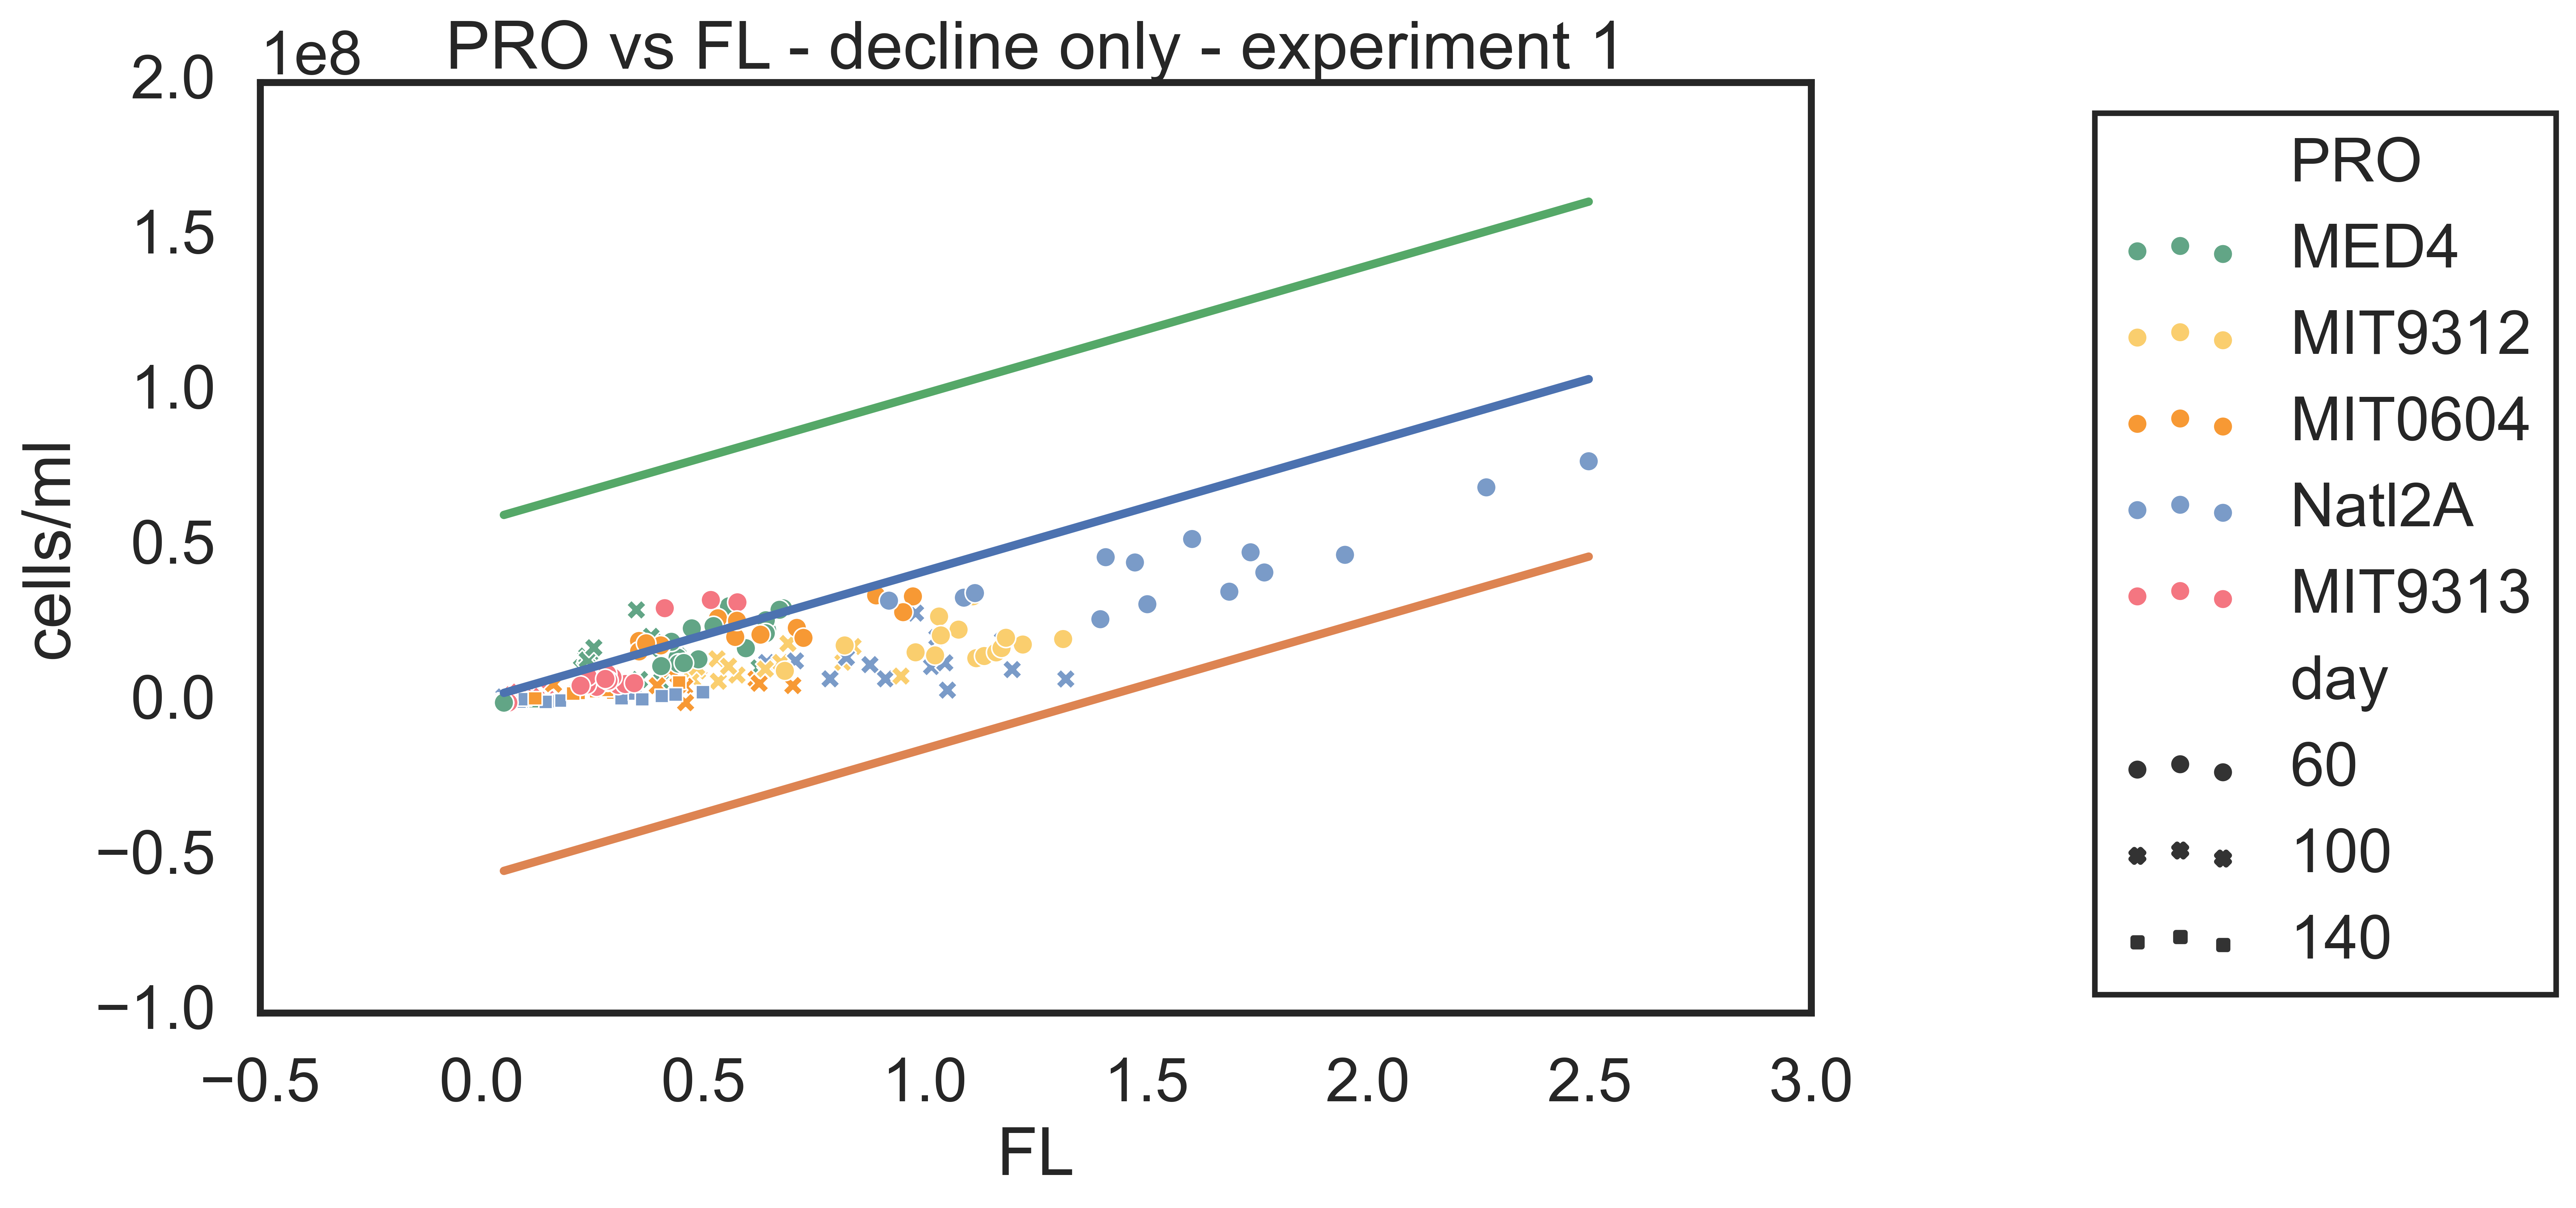

In [119]:
dt = res.get_prediction(sm.add_constant(df_fl['FL'])).summary_frame(alpha = 0.05)
y_pred = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

sns.scatterplot(x=df_fl.FL, y=df_fl['PRO.1'], hue=df_fl.PRO, hue_order=porder, palette=ppallete, s=50,
               #style=df_fl.ALT,
                style=df_fl['day'])
sns.lineplot(x=df_fl['FL'], y=y_pred)
sns.lineplot(x=df_fl['FL'], y=yprd_ci_lower)
sns.lineplot(x=df_fl['FL'], y=yprd_ci_upper)
plt.ylabel('cells/ml')
plt.title('PRO vs FL - decline only - experiment 1')
plt.legend(bbox_to_anchor=(1.5,1))

rmse(df_fl['PRO.1'], y_pred), r2_score(df_fl['PRO.1'], y_pred)



In [120]:
dt = res.get_prediction(sm.add_constant(decline_compdf['FL'])).summary_frame(alpha = 0.05)
y_pred = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

sns.scatterplot(x=decline_compdf.FL, y=decline_compdf.FCM, hue=decline_compdf1.PRO, 
                hue_order=porder, palette=ppallete, style=decline_compdf1.MODE, s=50)
sns.lineplot(x=decline_compdf['FL'], y=y_pred)
sns.lineplot(x=decline_compdf['FL'], y=yprd_ci_lower)
sns.lineplot(x=decline_compdf['FL'], y=yprd_ci_upper)
plt.ylabel('cells/ml')
plt.title('PRO vs FL - decline only - previous experiments')
plt.legend(bbox_to_anchor=(1.5,1))


rmse(decline_compdf['FCM'], y_pred), r2_score(decline_compdf['FCM'], y_pred)

NameError: name 'decline_compdf1' is not defined

In [ ]:
dt = res.get_prediction(sm.add_constant(decline_compdf1['FL'])).summary_frame(alpha = 0.05)
y_pred = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

sns.scatterplot(x=decline_compdf1.FL, y=decline_compdf1.FCM, hue=decline_compdf1.day, 
                #hue_order=porder, palette=ppallete, style=decline_compdf1.MODE, 
                s=50)
sns.lineplot(x=decline_compdf1['FL'], y=y_pred)
sns.lineplot(x=decline_compdf1['FL'], y=yprd_ci_lower)
sns.lineplot(x=decline_compdf1['FL'], y=yprd_ci_upper)
plt.ylabel('cells/ml')
plt.title('PRO vs FL - decline only - previous experiments')
plt.legend(bbox_to_anchor=(1.5,1))


rmse(decline_compdf1['FCM'], y_pred), r2_score(decline_compdf1['FCM'], y_pred)

In [ ]:
prevfcm_df = cp.get_prev_fcm_df()
d = prevfcm_df.loc[prevfcm_df.METHOD == 'FL']
def get_max_day(x):
    maxidx = x['VALUE'].idxmax()
    maxday = x.loc[maxidx]['day']
    return maxday
max_days = d.groupby('EXP').apply(get_max_day)
decline_compdf = compdf.loc[compdf['day'] >= max_days[compdf['EXP']].values]

In [ ]:
no0_compdf= compdf.loc[compdf.FCM > 1e6]

In [ ]:
X = no0_compdf['FL']
y = no0_compdf['FCM']
res = sm.OLS(y, sm.add_constant(X)).fit()
print(res.summary())

In [ ]:
df_fl.head()

In [ ]:
dt = res.get_prediction(sm.add_constant(df_fl['FL'])).summary_frame(alpha = 0.05)
y_pred = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

sns.scatterplot(x=df_fl.FL, y=df_fl['PRO.1'], hue=df_fl.PRO, hue_order=porder, palette=ppallete, s=50,
               #style=df_fl.ALT,
                style=df_fl['day'])
sns.lineplot(x=df_fl['FL'], y=y_pred)
sns.lineplot(x=df_fl['FL'], y=yprd_ci_lower)
sns.lineplot(x=df_fl['FL'], y=yprd_ci_upper)
plt.ylabel('cells/ml')
plt.title('PRO vs FL - decline only - experiment 1')
plt.legend(bbox_to_anchor=(1.5,1))

rmse(df_fl['PRO.1'], y_pred), r2_score(df_fl['PRO.1'], y_pred)



In [ ]:
dt = res.get_prediction(sm.add_constant(decline_compdf1['FL'])).summary_frame(alpha = 0.05)
y_pred = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

sns.scatterplot(x=decline_compdf1.FL, y=decline_compdf1.FCM, hue=decline_compdf1.PRO, 
                hue_order=porder, palette=ppallete, style=decline_compdf1.MODE, s=50)
sns.lineplot(x=decline_compdf1['FL'], y=y_pred)
sns.lineplot(x=decline_compdf1['FL'], y=yprd_ci_lower)
sns.lineplot(x=decline_compdf1['FL'], y=yprd_ci_upper)
plt.ylabel('cells/ml')
plt.title('PRO vs FL - decline only - previous experiments')
plt.legend(bbox_to_anchor=(1.5,1))


rmse(decline_compdf1['FCM'], y_pred), r2_score(decline_compdf1['FCM'], y_pred)

In [ ]:
compdf.shape